In [ ]:
# !pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(rootpath+'/package')
from utils.env_pca import env
from model.qagent import QAgent
from service.measurerss import measureRSS
from model.pathlossmodel import PathLossModel, NoiseMaker

In [ ]:
import csv
import pickle
import numpy as np
from scipy.special import comb, perm
from itertools import combinations
from service.combinationset import combinationSet
from model.uav import UAV
import keras

In [50]:
!pip install keras

In [51]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 13.2 MB/s 


In [ ]:
div = 30
pick = 1
threshold = 0.28518927+0.09565228
dataFolder = "/0811_MDS"

In [ ]:
import os
if not (os.path.isfile(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/result.csv")):
  f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/result.csv", 'wb')
  f.close()

In [ ]:
# load vae model
from keras import backend as K
modelPath = rootpath+"/datas/trainingModel/VAENoanchorMDSModel_300sample_8UAV_8uUAV_div"+str(div)
vae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/UAVsSamples_pick{}div{}_100.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)


{0: {0: <model.uav.UAV object at 0x7f907baa5490>, 1: <model.uav.UAV object at 0x7f907ba94bd0>, 2: <model.uav.UAV object at 0x7f907ba945d0>, 3: <model.uav.UAV object at 0x7f907b6c7950>, 4: <model.uav.UAV object at 0x7f907b6b6c90>, 5: <model.uav.UAV object at 0x7f907b6b6450>, 6: <model.uav.UAV object at 0x7f907b6b6a90>, 7: <model.uav.UAV object at 0x7f907b6b6690>, 8: <model.uav.UAV object at 0x7f907b694dd0>, 9: <model.uav.UAV object at 0x7f907b68fc10>, 10: <model.uav.UAV object at 0x7f907b693c10>, 11: <model.uav.UAV object at 0x7f907b6aca50>, 12: <model.uav.UAV object at 0x7f907b6ac890>, 13: <model.uav.UAV object at 0x7f907b638410>, 14: <model.uav.UAV object at 0x7f907b6381d0>, 15: <model.uav.UAV object at 0x7f907bc49e90>}, 1: {0: <model.uav.UAV object at 0x7f907b5f0290>, 1: <model.uav.UAV object at 0x7f907b5e1710>, 2: <model.uav.UAV object at 0x7f907c8e07d0>, 3: <model.uav.UAV object at 0x7f907b81ac10>, 4: <model.uav.UAV object at 0x7f907bc12d50>, 5: <model.uav.UAV object at 0x7f9079649

In [ ]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)

In [ ]:
groupListSamples = combinationSet(UAVsSamples)
SizeOfGroupsCombination = 0
for INumberOfCombination, GroupsOfConbination  in groupListSamples[0].items():
  for IConbination in GroupsOfConbination:
    SizeOfGroupsCombination+=1

In [ ]:
_sdpResultsDatas = []
for j in range(env.N_ngps):
  with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/test_position{}_pickerror{}_deviation{}_100.csv".format(j,pick,div), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    _sdpResultsDatas.append(csvReader)
ShapeOfSDPResultsData = np.array(_sdpResultsDatas).shape
sdpResultsDatas = np.array(_sdpResultsDatas).reshape(env.N_ngps,ShapeOfSDPResultsData[1]//SizeOfGroupsCombination,SizeOfGroupsCombination,env.DIMENSION)
PositionOfTargetsUAVOfGroupOfSample = sdpResultsDatas.transpose((1,2,0,3))
np.array(PositionOfTargetsUAVOfGroupOfSample).shape
PositionOfTargetsUAVOfGroupOfSample = PositionOfTargetsUAVOfGroupOfSample

In [ ]:
PositionOfTargetsUAVOfGroupOfSample.shape

(100, 93, 8, 2)

In [ ]:
from service.combinationset import groupingFromSet
from model.sdp import calculateSDP
states = {}
currentSdpResultsDatas = {}
groupLists = combinationSet(UAVsSamples)
for iSample in UAVsSamples:
  currentSdpResultsDatas[iSample]= {}
  states[iSample] = []
  for s, groupList in groupLists[iSample].items():
    for group in groupList:
      states[iSample].append(group)
  for iState, state in enumerate(states[iSample]):
    groupOfState = groupingFromSet(state)  
    currentSdpResultsDatas[iSample][iState] = []  
    for iNumberOfGroup in groupOfState:
      if len(groupOfState[iNumberOfGroup]) > 0:
        for group in groupOfState[iNumberOfGroup]:
          if group in states[iSample]:
            indexOfGroup = states[iSample].index(group)
            currentSdpResultsDatas[iSample][iState].append(PositionOfTargetsUAVOfGroupOfSample[iSample][indexOfGroup])

In [ ]:
from itertools import combinations
allEstimateGroups = {}
states = {}
for iSample in UAVsSamples:
  allEstimateGroups[iSample] = {}
  UAVsSample = UAVsSamples[iSample]
  groupListSample = combinationSet({0:UAVsSample})[0]

  states[iSample] = []
  for s, groupList in groupListSample.items():
    for group in groupList:
      states[iSample].append(group)

  for iState, state in enumerate(states[iSample]):
    # print(len(state),len(state)-(env.DIMENSION+1))
    for kickNumber in range(len(state)-(3+1)):
      # print(kickNumber)
      for ikick in range(kickNumber+1):
        estimateGroups = list(combinations(state,len(state)-ikick))
        allEstimateGroups[iSample][iState] = estimateGroups
print(len(allEstimateGroups[0]))

93


In [ ]:
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)), axis=1)

In [ ]:
sdpOfSubGroupOfState= {} # state > index in estimateGroup > sdp
for iSample in UAVsSamples:
  sdpOfSubGroupOfState[iSample]= {}
  pathLossModel = PathLossModel()
  for iEstimateGroups in allEstimateGroups[iSample]:
    sdpOfSubGroup = {}
    sdpResultsDatas = None
    rawDatas = []
    ReadSampleSize = 1
    estimateGroups = list(map(list, allEstimateGroups[iSample][iEstimateGroups]))
    groupSize = np.array(estimateGroups).shape[0]
    for iEstimateGroup, estimateGroup in enumerate(estimateGroups):
      stateIndex = states[iSample].index(estimateGroup)
      sdpOfSubGroup[iEstimateGroup] = currentSdpResultsDatas[iSample][stateIndex]
    sdpOfSubGroupOfState[iSample][iEstimateGroups] = sdpOfSubGroup

In [ ]:
vaeOutputs = {}
normalizeVAETestingDatas = {}
for iSample in UAVsSamples:
  print("iSample",iSample)
  vaeOutputs[iSample] = []
  normalizeVAETestingDatas[iSample] = []
  for iState in allEstimateGroups[iSample]:
    estimateGroups = []    
    for iEstimateGroup, estimateGroup in enumerate(allEstimateGroups[iSample][iState]):
      estimateGroups.append(estimateGroup)
    dualGroupingTestingData = []
    for groupOfI in estimateGroups:
      for groupOfJ in estimateGroups:
        indexOfSubGroupInStateOfI = allEstimateGroups[iSample][iState].index(groupOfI)
        indexOfSubGroupInStateOfJ = allEstimateGroups[iSample][iState].index(groupOfJ)
        firstTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfI]).copy().tolist()
        secondTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfJ]).copy().tolist()
        # list (map(lambda i: firstTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
        # list (map(lambda i: secondTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
        dualGroupingTestingData.append([firstTrainingPickGroupData, secondTrainingPickGroupData])
    dualGroupingTestingData = np.array(dualGroupingTestingData).astype('float32')  
    VAETestingData = dualGroupingTestingData.reshape(len(dualGroupingTestingData), np.prod(dualGroupingTestingData.shape[1:]))
    # VAETestingData = dualGroupingTestingData.reshape((dualGroupingTestingData.shape[0],
    #       dualGroupingTestingData.shape[3],
    #       dualGroupingTestingData.shape[1],
    #       dualGroupingTestingData.shape[4],
    #       dualGroupingTestingData.shape[2]))   
    data_min = 0
    data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)
    normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
    normalizeVAETestingData = normalizeVAETestingData.astype('float32')
    # print(np.array(normalizeVAETestingData).shape)
    vaeOutput = vae.predict(normalizeVAETestingData, batch_size = 2048*4)
    vaeOutputs[iSample].append(vaeOutput)
    normalizeVAETestingDatas[iSample].append(normalizeVAETestingData)



iSample 0
iSample 1
iSample 2
iSample 3
iSample 4
iSample 5
iSample 6
iSample 7
iSample 8
iSample 9
iSample 10
iSample 11
iSample 12
iSample 13
iSample 14
iSample 15
iSample 16
iSample 17
iSample 18
iSample 19
iSample 20
iSample 21
iSample 22
iSample 23
iSample 24
iSample 25
iSample 26
iSample 27
iSample 28
iSample 29
iSample 30
iSample 31
iSample 32
iSample 33
iSample 34
iSample 35
iSample 36
iSample 37
iSample 38
iSample 39
iSample 40
iSample 41
iSample 42
iSample 43
iSample 44
iSample 45
iSample 46
iSample 47
iSample 48
iSample 49
iSample 50
iSample 51
iSample 52
iSample 53
iSample 54
iSample 55
iSample 56
iSample 57
iSample 58
iSample 59
iSample 60
iSample 61
iSample 62
iSample 63
iSample 64
iSample 65
iSample 66
iSample 67
iSample 68
iSample 69
iSample 70
iSample 71
iSample 72
iSample 73
iSample 74
iSample 75
iSample 76
iSample 77
iSample 78
iSample 79
iSample 80
iSample 81
iSample 82
iSample 83
iSample 84
iSample 85
iSample 86
iSample 87
iSample 88
iSample 89
iSample 90
iSample 9

In [ ]:
f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_vaeOutputs_pick{}_div{}.pkl".format(pick,div), "wb")
pickle.dump(vaeOutputs, f)
f.close()

f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_normalizeVAETestingDatas_pick{}_div{}.pkl".format(pick,div), "wb")
pickle.dump(normalizeVAETestingDatas, f)
f.close()

In [ ]:
f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_vaeOutputs_pick{}_div{}.pkl".format(pick,div), "rb")
vaeOutputs = pickle.load(f)
f.close()
f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_normalizeVAETestingDatas_pick{}_div{}.pkl".format(pick,div), "rb")
normalizeVAETestingDatas = pickle.load(f)
f.close()

In [ ]:
optimalMSE = {}
optimalMSEGroup = {}
def runVAEOutput(iSample):
  print("iSample",iSample)
  _optimalMSE = []
  _optimalMSEGroup = []
  UAVsSample = UAVsSamples[iSample]
  
  for iState in allEstimateGroups[iSample]:
    try:
      mse = MSE(vaeOutputs[iSample][iState], normalizeVAETestingDatas[iSample][iState])
      # if iState %10 == 0:
        # print("iState:",iSample,iState)
      _optimalMSE.append(mse)
      _optimalMSEGroup.append(states[iSample][iState])
    except:
      continue    
  optimalMSE[iSample] = _optimalMSE
  optimalMSEGroup[iSample] = _optimalMSEGroup
  print("finish")
for iSample in UAVsSamples:
  runVAEOutput(iSample)

iSample 0
finish
iSample 1
finish
iSample 2
finish
iSample 3
finish
iSample 4
finish
iSample 5
finish
iSample 6
finish
iSample 7
finish
iSample 8
finish
iSample 9
finish
iSample 10
finish
iSample 11
finish
iSample 12
finish
iSample 13
finish
iSample 14
finish
iSample 15
finish
iSample 16
finish
iSample 17
finish
iSample 18
finish
iSample 19
finish
iSample 20
finish
iSample 21
finish
iSample 22
finish
iSample 23
finish
iSample 24
finish
iSample 25
finish
iSample 26
finish
iSample 27
finish
iSample 28
finish
iSample 29
finish
iSample 30
finish
iSample 31
finish
iSample 32
finish
iSample 33
finish
iSample 34
finish
iSample 35
finish
iSample 36
finish
iSample 37
finish
iSample 38
finish
iSample 39
finish
iSample 40
finish
iSample 41
finish
iSample 42
finish
iSample 43
finish
iSample 44
finish
iSample 45
finish
iSample 46
finish
iSample 47
finish
iSample 48
finish
iSample 49
finish
iSample 50
finish
iSample 51
finish
iSample 52
finish
iSample 53
finish
iSample 54
finish
iSample 55
finish
iS

In [ ]:
# loadanomaly = np.load(rootpath+"/datas/anomalySDPResult"+"/0706/anomalyUAVs_pick1div{}_300.npy".format(40),allow_pickle=True)
import pickle as dill
anomalyUAVs = []
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/anomalyUAVs_pick{}div{}_100.npy".format(pick,div), 'rb') as f:
  while True:
    try:
      anomalyUAVs.append(dill.load(f))
    except EOFError:
      break
print(anomalyUAVs)

[[11], [2], [13], [0], [2], [7], [6], [13], [7], [3], [14], [13], [11], [10], [7], [15], [2], [15], [12], [12], [13], [8], [10], [11], [7], [4], [5], [2], [9], [3], [15], [11], [14], [7], [1], [3], [8], [14], [10], [11], [11], [15], [15], [3], [7], [11], [14], [13], [11], [11], [8], [0], [6], [0], [4], [0], [8], [6], [8], [10], [9], [4], [7], [11], [11], [5], [5], [14], [13], [4], [4], [13], [9], [3], [4], [10], [11], [5], [10], [13], [6], [0], [12], [3], [8], [0], [1], [5], [10], [3], [12], [0], [11], [0], [12], [4], [15], [6], [3], [6]]


In [ ]:
# import pickle as dill
# _anomalyUAVsSamples = {}
# anomalyUAVs = []
# iSample = 0
# with open(rootpath+"/datas/anomalySDPResult"+"/done0706/UAVsSamples_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
#   while True:
#     if iSample >= env.LOAD_SAMPLES_FOR_AE:
#        break
#     try:
#       _anomalyUAVsSamples[iSample] = dill.load(f)
#       iSample += 1
#     except EOFError:
#       break
# anomalyUAVsSamples = _anomalyUAVsSamples
# print(_anomalyUAVsSamples)
# for iSample in UAVsSample:
#   _anomalyUAVs = []
#   for _, uav in anomalyUAVsSamples[iSample].items():    
#     if uav.observedPosition != uav.realPosition and uav.observedPosition != None :
#       _anomalyUAVs.append(uav.id)
#   anomalyUAVs.append(_anomalyUAVs)
# print(anomalyUAVs)

In [ ]:
anomalyUAVsSample = {}
for iSample in UAVsSamples:
  anomalyUAV = []
  for IDOfUAV in UAVsSamples[iSample]:
    uav = UAVsSamples[iSample][IDOfUAV]
    if not uav.observedPosition == None:
      if not uav.observedPosition == uav.realPosition:
        anomalyUAV.append(IDOfUAV)
  anomalyUAVsSample[iSample] = anomalyUAV
anomalyUAVs = anomalyUAVsSample

optimalGroup  5 : [3, 4, 6, 9, 12] 0.2600258 0.0
optimalGroup  52 : [6, 8, 9, 12, 15] 0.2510234 0.0
optimalGroup  40 : [4, 6, 8, 12, 15] 0.24052507 0.0
optimalGroup [4, 6, 8, 12, 15]
optimalGroup  47 : [4, 8, 10, 12, 14] 0.23710224 0.0
optimalGroup  49 : [4, 10, 11, 12, 14] 0.19648723 0.0
optimalGroup  54 : [5, 10, 11, 12, 14] 0.18203461 0.0
optimalGroup [5, 10, 11, 12, 14]
optimalGroup  12 : [0, 3, 5, 6, 14] 0.19140014 0.0
optimalGroup  31 : [0, 5, 6, 10, 14] 0.18654245 0.0
optimalGroup  17 : [0, 3, 6, 10, 14] 0.1137414 0.0
optimalGroup [0, 3, 6, 10, 14]
optimalGroup  35 : [1, 5, 6, 7, 8] 0.20017254 0.0
optimalGroup  46 : [1, 6, 7, 8, 12] 0.19585046 0.0
optimalGroup  41 : [1, 5, 7, 8, 11] 0.18899408 0.0
optimalGroup [1, 5, 7, 8, 11]
optimalGroup  52 : [4, 9, 11, 14, 15] 0.2508762 0.0
optimalGroup  20 : [0, 4, 9, 11, 13] 0.24622989 0.0
optimalGroup  23 : [0, 4, 9, 13, 14] 0.18546617 0.0
optimalGroup [0, 4, 9, 13, 14]
optimalGroup  44 : [1, 5, 10, 12, 13] 0.20163465 0.0
optimalGroup  26

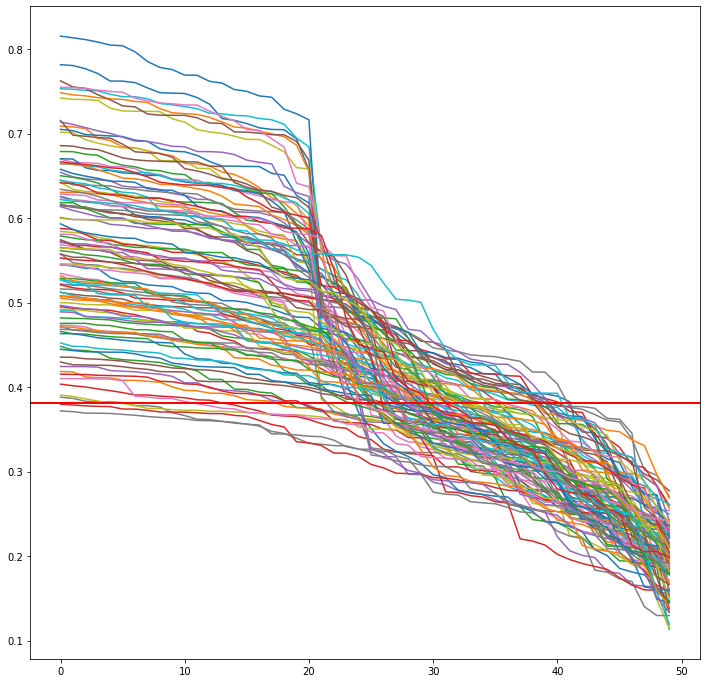

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
aggregateMSE = {}
for iSample in UAVsSamples:
  aggregateMSE[iSample] ={}  
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  for i in sortIndex[-3:]:
    print("optimalGroup ",i,":",optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
  aggregateMSE[iSample] = []
  for i in range(len(optimalMSE[iSample])):
    aggregateMSE[iSample].append(np.mean(optimalMSE[iSample][i]))
  index = np.argmin(aggregateMSE[iSample])
  print("optimalGroup",optimalMSEGroup[iSample][index])
  # print("anomalyUAVs",anomalyUAVs[iSample])
  ax1.plot(sortOptionalMSE[-50:])
  ax1.axhline(y = threshold, color = 'r', linestyle = '-')
  plt.grid()


1
19.408828068497705 22.691171931502296
[ 8 21 31 21 19 23 25 18 16 24 22 32 15 36 30 24 22 10 18 12 20 20 24 20
 25 23 21 44 21 22 20 24 21 18 10 14 19  9 28 17 26 19 10 51 21 25 20 17
 21 15 20 11 24 24 25 11 23 28 23 18 23 14 26 30 15 10 22 24 44 21 24 17
 22  9 21 11 39 17 17 20 10 21 20 18 10 21 14 56 15 23 24 25 17 20 22 11
 25 22 17  9]
100
65


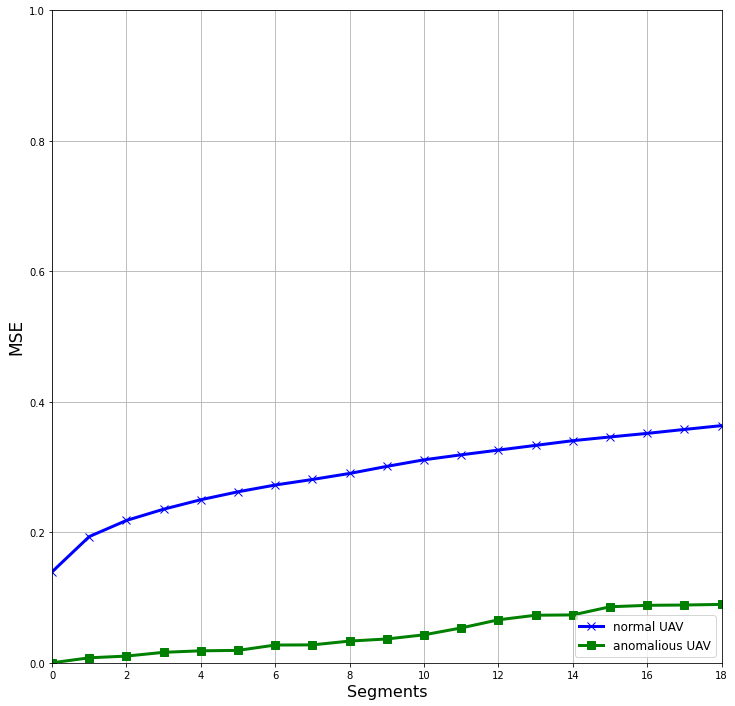

In [ ]:
import matplotlib.pyplot as plt
# threshold = 0.32+0.07
print(pick)
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
sumY = np.zeros(len(optimalMSE[0]))
sumAnomalyY = np.zeros(len(optimalMSE[0]))
sumthreaholdIndex = []
thresholdSampleSize = 100
for iSample in UAVsSamples:
  if not iSample < thresholdSampleSize:
    break
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  PDFWindowsMemberTable = {}
  anomalyId = []
  threaholdIndex = 0
  for iUAV,uav in UAVsSamples[iSample].items():
    if uav.observedPosition != None:
      PDFWindowsMemberTable[uav.id] = []
      if uav.observedPosition != uav.realPosition:
        anomalyId.append(uav.id)
        # print(uav.id,uav.observedPosition,uav.realPosition,np.linalg.norm(np.array(uav.observedPosition)-np.array(uav.realPosition)))
  for i in range(0,len(sortIndex)):
    if sortOptionalMSE[i] > threshold:
      threaholdIndex = i
      sumthreaholdIndex.append(i)
      break
  # print(WindowsMemberTable)
  for iWindows in range(0,len(sortIndex)):
    memberTable = {}
    for groupMember in optimalMSEGroup[iSample][sortIndex[iWindows]]:
      try:
        memberTable[groupMember] += sortOptionalMSE[iWindows]
      except:
        memberTable[groupMember] = sortOptionalMSE[iWindows]
    for UAVId in PDFWindowsMemberTable:
      isHaveValue = False
      for member, value in memberTable.items():
        if member == UAVId:
          PDFWindowsMemberTable[UAVId].append(value)
          isHaveValue = True
      if not isHaveValue:
        if len(PDFWindowsMemberTable[UAVId]) > 0:
          PDFWindowsMemberTable[UAVId].append(PDFWindowsMemberTable[UAVId][-1])
        else:
          PDFWindowsMemberTable[UAVId].append(0)
  _sumY = np.zeros(len(optimalMSE[iSample]))
  _sumAnomalyY = np.zeros(len(optimalMSE[iSample]))
  for UAVId in PDFWindowsMemberTable:
    # print(UAVId, PDFWindowsMemberTable[UAVId])
    from scipy.interpolate import make_interp_spline
    x = np.arange(0,len(PDFWindowsMemberTable[UAVId]))
    y = PDFWindowsMemberTable[UAVId]
    # model=make_interp_spline(x,y)
    # xs=np.linspace(1,15,5000)
    # ys=model(xs)
    lineColor = 'b'
    if UAVId in anomalyId:
      lineColor = 'g'
    # ax1.plot(x,y,linestyle='-', c=lineColor, alpha=1/(1*thresholdSampleSize))
    if UAVId in anomalyId:
      for iyv, _xv in enumerate(y):
        _sumAnomalyY[iyv] += _xv
    else:
      for iyv, _yv in enumerate(y):
        _sumY[iyv] += _yv
  # print(_sumY)
  sumY += _sumY/(env.N_gps - len(anomalyId))
  sumAnomalyY += _sumAnomalyY/(len(anomalyId))
    # ax1.legend()
  # ax1.plot( np.arange(0,len(sortOptionalMSE)),sortOptionalMSE[::-1])
  # ax1.axvline(x=threaholdIndex,linestyle='-', c='r', alpha=1/(2*thresholdSampleSize))
  # ax1.legend()
meanY = sumY/(thresholdSampleSize)
meanAnomalyY = sumAnomalyY/(thresholdSampleSize)
import numpy as np, scipy.stats as st
lower,upper = st.t.interval(0.95, len(sumthreaholdIndex)-1, loc=np.mean(sumthreaholdIndex), scale=st.sem(sumthreaholdIndex))
print(lower,upper)
ax1.plot(x,meanY, label= "normal UAV",linestyle='-', c='b', linewidth=3, marker = 'x', markersize=8)
ax1.plot(x,meanAnomalyY, label= "anomalious UAV",linestyle='-', c='g', linewidth=3, marker = 's', markersize=8)
sumthreaholdIndex = np.array(sumthreaholdIndex)
print(sumthreaholdIndex)
# sumthreaholdIndex = np.array(sumthreaholdIndex)[sumthreaholdIndex >lower]
print(len(sumthreaholdIndex))
sumthreaholdIndex = sumthreaholdIndex[sumthreaholdIndex < upper]
print(len(sumthreaholdIndex))
# ax1.axvline(x=np.mean(sumthreaholdIndex), label= "cutting", c='r', linewidth=3)
ax1.legend(loc='lower right', prop={'size': 12})
ax1.set_xlabel('Segments', fontsize=16)
ax1.set_ylabel('MSE', fontsize=17)
# ax1.set_title('{} div {} pick {}'.format(dataFolder.split("_")[1], div, pick))
ax1.set_ylim([0,1])
ax1.set_xlim([0,18])
plt.grid()

# plt.savefig(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/appearance{}_{}".format(div,pick))
# plt.savefig(rootpath+"/datas/anomalyNewSDPResult/appearanceMDS{}_{}".format(div,pick))

In [ ]:
avgY = list (map(lambda x: np.around(x, 3), meanY))
avgAnomalyY = list (map(lambda x: np.around(x, 3), meanAnomalyY))
print(avgY)
print(avgAnomalyY)

[0.139, 0.194, 0.218, 0.236, 0.25, 0.262, 0.273, 0.281, 0.29, 0.301, 0.311, 0.319, 0.326, 0.333, 0.341, 0.346, 0.352, 0.358, 0.364, 0.37, 0.378, 0.386, 0.395, 0.405, 0.416, 0.427, 0.438, 0.45, 0.462, 0.491, 0.501, 0.51, 0.516, 0.521, 0.525, 0.529, 0.533, 0.537, 0.54, 0.543, 0.546, 0.548, 0.551, 0.553, 0.556, 0.558, 0.56, 0.562, 0.564, 0.566, 0.569, 0.571, 0.573, 0.576, 0.578, 0.58, 0.582, 0.584, 0.586, 0.589, 0.591, 0.594, 0.596, 0.598, 0.601, 0.603, 0.606, 0.608, 0.611, 0.614, 0.617, 0.62, 0.623, 0.627, 0.631, 0.636, 0.641, 0.646, 0.653, 0.66, 0.668, 0.678, 0.69, 0.703, 0.718, 0.732, 0.746, 0.758, 0.772, 0.786, 0.803, 0.82, 0.841]
[0.0, 0.008, 0.01, 0.016, 0.018, 0.019, 0.027, 0.027, 0.033, 0.037, 0.043, 0.053, 0.066, 0.073, 0.073, 0.086, 0.088, 0.089, 0.09, 0.095, 0.105, 0.123, 0.143, 0.158, 0.184, 0.212, 0.258, 0.271, 0.305, 0.495, 0.503, 0.512, 0.518, 0.523, 0.527, 0.53, 0.534, 0.538, 0.541, 0.544, 0.546, 0.549, 0.551, 0.554, 0.556, 0.559, 0.561, 0.563, 0.565, 0.567, 0.57, 0.572, 0

In [ ]:
# threshold = 0.32+0.07
memberTableSample = {}
for iSample in UAVsSamples:
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]

  memberTable = {}
  for i in sortIndex:
    if np.mean(optimalMSE[iSample][i]) < threshold:
      print(optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
      for groupMember in optimalMSEGroup[iSample][i]:
        try:
          memberTable[groupMember] += 1
        except:
          memberTable[groupMember] = 1
  memberTableSample[iSample] = memberTable
  print(len(memberTableSample[iSample]))
# print(memberTableSample)

memberIdSample = {}
memberAmountSample = {}
for iSample, memberTableOfSample in memberTableSample.items():
  memberId = []
  memberAmount = []
  for iMember, amount in memberTableOfSample.items():
    memberId.append(iMember)
    memberAmount.append(amount)
  memberIdSample[iSample] = memberId
  memberAmountSample[iSample] = memberAmount

[0, 4, 6, 7, 8] 0.24092336 0.0
5
[3, 10, 12, 13, 15] 0.21120344 0.0
5
[1, 3, 10, 13, 14] 0.3705334 0.0
5
[0, 2, 4, 5, 14] 0.2544518 0.0
5
[3, 4, 7, 10, 13] 0.35002935 0.0
[3, 4, 7, 8, 13] 0.32990217 0.0
[4, 7, 8, 10, 13] 0.31388736 0.0
[3, 4, 7, 8, 10, 13] 0.29457542 0.03098493
[3, 4, 8, 10, 13] 0.2655124 0.0
[3, 7, 8, 10, 13] 0.25599414 0.0
[3, 4, 7, 8, 10] 0.25212726 0.0
6
0
[0, 1, 11, 13, 14] 0.3696488 0.0
5
0
[4, 5, 10, 13, 14] 0.27137545 0.0
5
[3, 5, 7, 10, 12] 0.302216 0.0
5
[2, 3, 8, 12, 15] 0.332874 0.0
[2, 3, 6, 8, 12] 0.22099704 0.0
6
[6, 7, 10, 12, 13] 0.34545976 0.0
5
[0, 1, 2, 8, 9] 0.35148224 0.0
[0, 1, 6, 8, 12] 0.3208312 0.0
[0, 1, 8, 9, 12] 0.2595319 0.0
7
[0, 8, 9, 11, 14] 0.33438855 0.0
5
[0, 3, 6, 7, 11] 0.17289528 0.0
5
[2, 3, 9, 12, 15] 0.29458466 0.0
5
[0, 4, 5, 9, 13] 0.2557941 0.0
5
[5, 6, 8, 12, 14] 0.22281039 0.0
5
[1, 4, 9, 12, 15] 0.36994952 0.0
[1, 2, 4, 12, 15] 0.3653893 0.0
[2, 4, 9, 12, 15] 0.36370385 0.0
6
[0, 1, 6, 12, 13] 0.17377865 0.0
5
[1, 2, 5, 1

In [ ]:
goodUAVsSample = {}
for iSample in UAVsSamples:
  trainMean = np.mean(memberAmountSample[iSample])
  trainStd = np.std(memberAmountSample[iSample])
  # print(trainMean, trainStd)
  upperBound = trainMean + trainStd*2
  lowerBound = trainMean - trainStd*2

  goodUAVID = []
  for i, v in memberTableSample[iSample].items():
    if lowerBound <= v and v <= upperBound:
      goodUAVID.append(i)
  # print(goodUAVID)
  goodUAVsSample[iSample] = goodUAVID

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
goodUAVsSample = {}
for iSample in UAVsSamples:
  trainSum = np.sum(memberAmountSample[iSample])
  confidenceSum = trainSum*0.9//1
  # print(trainSum, confidenceSum,memberAmountSample)
  candidateUAV = []
  sortMap = sorted(memberTableSample[iSample].items(), key=lambda x:x[1], reverse=True)
  # print(iSample,sortMap)
  for i, v in sortMap:
    for _ in range(v):
      candidateUAV.append(i)
  # print(candidateUAV) 
  goodUAVID = []
  for i, v in enumerate(candidateUAV):
    if i <= confidenceSum:
      if v in goodUAVID:
        continue
      else:
        goodUAVID.append(v)
  # print(goodUAVID)
  goodUAVsSample[iSample] = goodUAVID
  # break
# print(goodUAVsSample)

In [ ]:
import pickle as dill
_anomalyUAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/UAVsSamples_pick{}div{}_100.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _anomalyUAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
anomalyUAVsSamples = _anomalyUAVsSamples
print(_anomalyUAVsSamples)

{0: {0: <model.uav.UAV object at 0x7f93d924a610>, 1: <model.uav.UAV object at 0x7f93d924a910>, 2: <model.uav.UAV object at 0x7f93d924a290>, 3: <model.uav.UAV object at 0x7f93d924af10>, 4: <model.uav.UAV object at 0x7f93d924aed0>, 5: <model.uav.UAV object at 0x7f93d924a810>, 6: <model.uav.UAV object at 0x7f93d924ac90>, 7: <model.uav.UAV object at 0x7f93d924aad0>, 8: <model.uav.UAV object at 0x7f93d924a5d0>, 9: <model.uav.UAV object at 0x7f93d924a210>, 10: <model.uav.UAV object at 0x7f93d924a110>, 11: <model.uav.UAV object at 0x7f93d9f9e710>, 12: <model.uav.UAV object at 0x7f93d9f9e950>, 13: <model.uav.UAV object at 0x7f93d9f9ecd0>, 14: <model.uav.UAV object at 0x7f93d9f9ea50>, 15: <model.uav.UAV object at 0x7f93d9f9e210>}, 1: {0: <model.uav.UAV object at 0x7f93d924a390>, 1: <model.uav.UAV object at 0x7f93d9047ad0>, 2: <model.uav.UAV object at 0x7f93d9047950>, 3: <model.uav.UAV object at 0x7f93d9047a10>, 4: <model.uav.UAV object at 0x7f93d9047090>, 5: <model.uav.UAV object at 0x7f93d9047

In [ ]:
TP = 0
for iSample in goodUAVsSample:
  # print(anomalyUAVs[iSample],goodUAVsSample[iSample])
  for anomlayUAV in anomalyUAVs[iSample]:
    if not anomlayUAV in goodUAVsSample[iSample]:
      TP+= 1.0

TN = 0
for iSample in goodUAVsSample:
   for _, uav in anomalyUAVsSamples[iSample].items():
      # print(uav.id,goodUAVsSample[iSample])
      if uav.id in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None:
          TN += 1.0

FN = 0
for iSample in goodUAVsSample:
   for anomlayUAV in anomalyUAVs[iSample] :
      if anomlayUAV in goodUAVsSample[iSample]:
        FN += 1.0

FP = 0
for iSample in goodUAVsSample:
  #  for _, uav in UAVsSamples[iSample].items():
      # print(iSample,uav.id,goodUAVsSample[iSample],uav.observedPosition,uav.realPosition)
      # break
   for _, uav in anomalyUAVsSamples[iSample].items():
      if uav.id not in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None:
        # print("====",iSample,uav.id,goodUAVsSample[iSample],anomalyUAVs[iSample],uav.observedPosition,uav.realPosition)
        FP += 1.0
print("TP:",(TP/len(goodUAVsSample)) *100)
print("TN:",(TN/len(goodUAVsSample))*100)
print("FP:",(FP/len(goodUAVsSample)) *100)
print("FN:",(FN/len(goodUAVsSample))*100)
print("Precision:",(TP/(FP+TP))*100)
print("Recall:",(TP/(FN+TP))*100)
p = (TP/(FP+TP))*100
r = (TP/(FN+TP))*100
print("F1 score:",2*((p*r)/(p+r)))
# f = open(rootpath+"/datas/datas_forAnomalyDetection/BestAnchorsPCA/100sample_{}anomaly_{}div_SelectedAnchors_VAE.pkl".format(pick,div), "wb")
# pickle.dump(goodUAVsSample, f)
# f.close()


TP: 264.0
TN: 374.0
FP: 126.0
FN: 36.0
Precision: 67.6923076923077
Recall: 88.0
F1 score: 76.5217391304348


TP: 192.0
TN: 494.00000000000006
FP: 6.0
FN: 108.0
Precision: 96.96969696969697
Recall: 64.0
F1 score: 77.10843373493977

In [ ]:
# import csv

# with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/result.csv", 'a', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["Deviation_pick", "TP", "TN", "FP", "FN"])
#     writer.writerow(["{}_{}".format(div, pick), (TP/len(goodUAVsSample)) *100, (TN/len(goodUAVsSample))*100, (FP/len(goodUAVsSample)) *100, (FN/len(goodUAVsSample))*100])

In [ ]:
# div 10 pick 0
TP: 0.0
TN: 788.0
FP: 12.0
FN: 0.0
Precision: 0.0
Recall: 0

# div 10 pick 1
TP: 99.0
TN: 692.0
FP: 8.0
FN: 1.0
Precision: 92.5233644859813
Recall: 99.0

# div 10 pick 2
TP: 185.0
TN: 588.0
FP: 12.0
FN: 15.0
Precision: 93.90862944162437
Recall: 92.5

# div 10 pick 3
TP: 197.0
TN: 389.0
FP: 111.00000000000001
FN: 103.0
Precision: 63.961038961038966
Recall: 65.66666666666666

# ======================

# div 20 pick 0
TP: 0.0
TN: 785.0
FP: 15.0
FN: 0.0
Precision: 0.0
Recall: 0

# div 20 pick 1
TP: 96.0
TN: 695.0
FP: 5.0
FN: 4.0
Precision: 95.04950495049505
Recall: 96.0

# div 20 pick 2
TP: 192.0
TN: 593.0
FP: 7.000000000000001
FN: 8.0
Precision: 96.4824120603015
Recall: 96.0

# div 20 pick 3
TP: 209.0
TN: 400.0
FP: 100.0
FN: 91.0
Precision: 67.63754045307444
Recall: 69.66666666666667

# ======================

# div 30 pick 0
TP: 0.0
TN: 792.0
FP: 8.0
FN: 0.0
Precision: 0.0
Recall: 0

# div 30 pick 1
TP: 94.0
TN: 695.0
FP: 5.0
FN: 6.0
Precision: 94.94949494949495
Recall: 94.0

# div 30 pick 2
TP: 180.0
TN: 599.0
FP: 1.0
FN: 20.0
Precision: 99.4475138121547
Recall: 90.0

# div 30 pick 3
TP: 199.0
TN: 400.0
FP: 100.0
FN: 101.0
Precision: 66.5551839464883
Recall: 66.33333333333333

# ======================

# div 40 pick 0
TP: 0.0
TN: 797.0
FP: 3.0
FN: 0.0
Precision: 0.0
Recall: 0

# div 40 pick 1
TP: 97.0
TN: 699.0
FP: 1.0
FN: 3.0
Precision: 98.9795918367347
Recall: 97.0

# div 40 pick 2

# div 40 pick 3

# ======================

# div 50 pick 0

# div 50 pick 1
TP: 98.0
TN: 647.0
FP: 53.0
FN: 2.0
Precision: 64.90066225165563
Recall: 98.0

# div 50 pick 2
TP: 177.0
TN: 529.0
FP: 71.0
FN: 23.0
Precision: 71.37096774193549
Recall: 88.5

# div 50 pick 3
TP: 129.0
TN: 224.00000000000003
FP: 276.0
FN: 171.0
Precision: 31.851851851851855
Recall: 43.0

# ======================

# div 60 pick 0

# div 60 pick 1

# div 60 pick 2

# div 60 pick 3

# ======================

# div 70 pick 0

# div 70 pick 1

# div 70 pick 2

# div 70 pick 3

# ======================

# div 80 pick 0

# div 80 pick 1

# div 80 pick 2

# div 80 pick 3

# ======================

# div 90 pick 0

# div 90 pick 1

# div 90 pick 2

# div 90 pick 3
TP: 183.0
TN: 348.0
FP: 152.0
FN: 117.0
Precision: 54.62686567164179
Recall: 61.0

# ======================

# div 100 pick 0

# div 100 pick 1

# div 100 pick 2

# div 100 pick 3

# ======================

# 0.3796029 0.0869234
# div 200 pick 1
TP: 99.0
TN: 697.0
FP: 3.0
FN: 1.0
Precision: 97.05882352941177
Recall: 99.0

# div 200 pick 2
TP: 169.0
TN: 589.0
FP: 11.0
FN: 31.0
Precision: 93.88888888888889
Recall: 84.5

# div 200 pick 3
TP: 189.0
TN: 434.0
FP: 66.0
FN: 111.00000000000001
Precision: 74.11764705882354
Recall: 63.0

# ======================

# 0.29518927 0.09565228
# div 300 pick 1
TP: 97.0
TN: 695.0
FP: 5.0
FN: 3.0
Precision: 95.09803921568627
Recall: 97.0
F1: 96.03960396039604

# div 300 pick 2
TP: 179.0
TN: 594.0
FP: 6.0
FN: 21.0
Precision: 96.75675675675676
Recall: 89.5
F1: 92.98701298701299

# div 300 pick 3
TP: 187.0
TN: 384.0
FP: 115.99999999999999
FN: 112.99999999999999
Precision: 61.71617161716172
Recall: 62.33333333333333
F1: 62.02321724709784

# ======================

In [ ]:
precision = 61.71617161716172
recall = 62.33333333333333
f1 = 2*(precision*recall)/(precision+recall)
print(f1)

62.02321724709784
